#  <center> Problem Set 6 <center>

<center> 3.C01/3.C51, 10.C01/10.C51 <center>

In [1]:
# Cheminformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors,Crippen
from rdkit import RDLogger
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
RDLogger.DisableLog('rdApp.*')

# Arrays
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

# Statsmodels
import statsmodels.formula.api as sm

# Plotting 
import matplotlib.pyplot as plt
import matplotlib as mpl

# Personal utility package
import package.plot
from package.plot import get_size_inches
from pathlib import Path

# Machine learning
import torch
from torchmetrics.regression import R2Score
from torcheval.metrics.functional import r2_score as r2
from lightning import pytorch as pl
from lightning.pytorch.loggers import CSVLogger

# 10.1021/acs.jcim.3c01250
from chemprop import data, featurizers, models, nn
from chemprop.data.collate import NamedTuple, BatchMolGraph, Tensor, Iterable, Datum, collate_batch
from chemprop.data.dataloader import MoleculeDataset, ReactionDataset, MulticomponentDataset, DataLoader

# Utility
from datetime import datetime
from dataclasses import dataclass

# XGBoost
from xgboost import XGBRegressor

# Hyperparamter tuning
import optuna
from optuna_integration.pytorch_lightning import PyTorchLightningPruningCallback


/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def write(name,values):
    with open("results.csv", "a") as fhandle:
        fhandle.write(f"{name},{values}\n")

## Part 1: Baseline Regression Methods

### Part 1.1: (5 points) Prepare Dataset

In [5]:
data_dir = Path.cwd() / "data"
train_file = data_dir / "solvation_train.csv"
test_file = data_dir / "solvation_test.csv"
prop_file = data_dir / "molecule_props.csv"
df = pd.read_csv(train_file) # load data
mol_prop = pd.read_csv(prop_file)

Generate fingerprints (e.g. a Morgan fingerprint).

In [6]:
smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
mol = Chem.MolFromSmiles(smiles) # load SMILES into RDKit
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=512) # morgan fingerprint 
fp_array = np.zeros((1,), int) # convert to numpy array
DataStructs.ConvertToNumpyArray(fp, fp_array)

Generate various chemical properties.

In [6]:
MolWt = Descriptors.ExactMolWt(mol) # molecular weight
TPSA = Chem.rdMolDescriptors.CalcTPSA(mol) # Topological Polar Surface Area
nRotB = Descriptors.NumRotatableBonds(mol) # number of rotable bonds
HBD = Descriptors.NumHDonors(mol) # number of H bond donors
HBA = Descriptors.NumHAcceptors(mol) # number of H bond acceptors
logP = Descriptors.MolLogP(mol) # LogP
dct_pol = dict(zip(mol_prop["SMILES"],mol_prop["polarizability"]))
dct_dip = dict(zip(mol_prop["SMILES"],mol_prop["dipole"]))

Create a feature set with concatenated physical descriptors.

In [7]:
@dataclass
class PropFeaturizer(featurizers.Featurizer):
    def __init__(self, features: list):
        self.features = features

    def __len__(self) -> int:
        return len(self.features)

    def MolWt(self, mol):
        return Descriptors.ExactMolWt(mol)

    def TPSA(self, mol):
        return Chem.rdMolDescriptors.CalcTPSA(mol)
    
    def LASA(self, mol):
        return Chem.rdMolDescriptors.CalcLabuteASA(mol)

    def NumRotatableBonds(self, mol):
        return Descriptors.NumRotatableBonds(mol)

    def NumHDonors(self, mol):
        return Descriptors.NumHDonors(mol)

    def NumHAcceptors(self, mol):
        return Descriptors.NumHAcceptors(mol)

    def MolLogP(self, mol):
        return Descriptors.MolLogP(mol)

    def MolMR(self, mol):
        return Descriptors.MolMR(mol)

    def AromProp(self, mol):
        if mol.GetNumHeavyAtoms() > 0 :
            return len(list(mol.GetAromaticAtoms())) / mol.GetNumHeavyAtoms()
        else:
            return 0

    def __call__(self, mol: Chem.Mol) -> np.ndarray:
        return np.array([getattr(self,feature)(mol) for feature in self.features])

In [ ]:
features = ["TPSA", "LASA", "NumRotatableBonds", "NumHDonors", "NumHAcceptors", "MolLogP", "MolMR", "AromProp"]
def featurize(smiles):
    mol = Chem.MolFromSmiles(smiles) # load SMILES into RDKit
    fp = AllChem.GetMorganGenerator(radius=2, fpSize=1024)
    fp_array = np.array(fp.GetFingerprint(mol))
    featurizer = PropFeaturizer(features)
    return np.hstack([fp_array, featurizer(mol)])
y = df["logK"]
X_solvent = np.stack(df["Solvent"].apply(featurize).values)
X_solute = np.stack(df["Solute"].apply(featurize).values)
X = np.hstack([X_solvent,X_solute])

### 1.2 (10 points) Linear Regression

Train a linear regression model and report a 5-fold cross-validated R^2.

In [11]:
scaler = StandardScaler()
scores = cross_val_score(LinearRegression(), X, y, cv = 5, scoring = "r2")
print(f"No Regularization R2: {scores.mean()}")
write("linear",scores)
scores = cross_val_score(Lasso(), X, y, cv = 5, scoring = "r2")
print(f"Lasso R2: {scores.mean()}")
write("lasso",scores)
scores = cross_val_score(Ridge(), X, y, cv = 5, scoring = "r2")
print(f"Ridge R2: {scores.mean()}")
write("ridge",scores)

No Regularization R2: -4.636200160454372e+18
Lasso R2: 0.7189205413929178
Ridge R2: 0.9369656008111671


### 1.3 (10 points) MLP Regression

Train an MLP regression model and report a 5-fold cross-validated R^2.

In [49]:
# initialize a MLP with the specified hyperparameters
kwargs = {"hidden_layer_sizes" : (256,256,256),
          "activation" : "relu",
          "alpha" : 0.16,
          "solver" : "adam",
          "early_stopping" : False}
mlp =  MLPRegressor(**kwargs)
pipe = Pipeline([('scaler', StandardScaler()), ('model', mlp)])
scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
print(f"MLP R2: {scores.mean()}")
write("mlp",scores)

MLP R2: 0.961764313852596


## Part 2: (50 points) Machine Learning Competition and Report

You can start a new notebook here to put all your models.

In [ ]:
def save_submission(prediction, filename):
    '''
    Utility function to dump a submission file.

    prediction (numpy.array): 1d numpy array contains your prediction
    filename (str): file path to where you want to save the result
    '''
    sub = pd.DataFrame( {'index': list(range(len(prediction))), 'logK': prediction } )
    sub.to_csv(filename, index=False)

# Exploring the data

In [ ]:
def fp(smiles):
    mol = Chem.MolFromSmiles(smiles) # load SMILES into RDKit
    fp = AllChem.GetMorganGenerator(radius=2, fpSize=1024)
    fp_array = np.array(fp.GetFingerprint(Chem.MolFromSmiles("CC"),))
    featurizer = PropFeaturizer(features)
    return np.hstack([fp_array, featurizer(mol)])

In [ ]:
fp_solvent = np.stack(df["Solvent"].apply(fp).values)
fp_solute = np.stack(df["Solute"].apply(fp).values)
fps = np.hstack([fp_solvent,fp_solute])
scaler = StandardScaler()
fps_normed = scaler.fit_transform(fps)
y_normed = scaler.fit_transform(y.values.reshape(-1,1))
tsne = TSNE(perplexity=30)
pca = PCA()
fps_tsne = tsne.fit_transform(fps_normed)
fps_pca = pca.fit_transform(fps_normed)

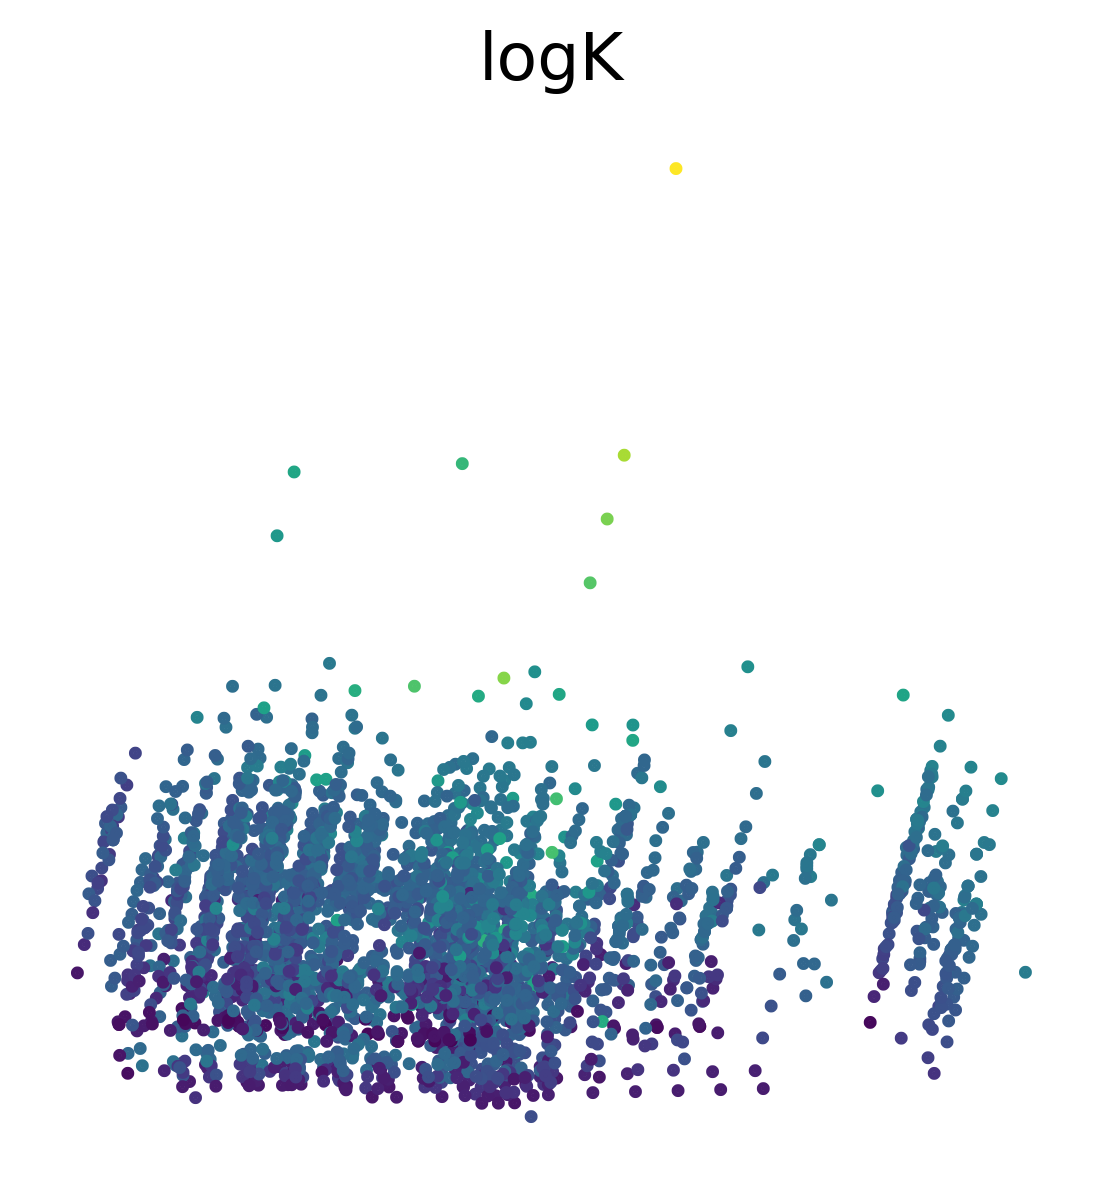

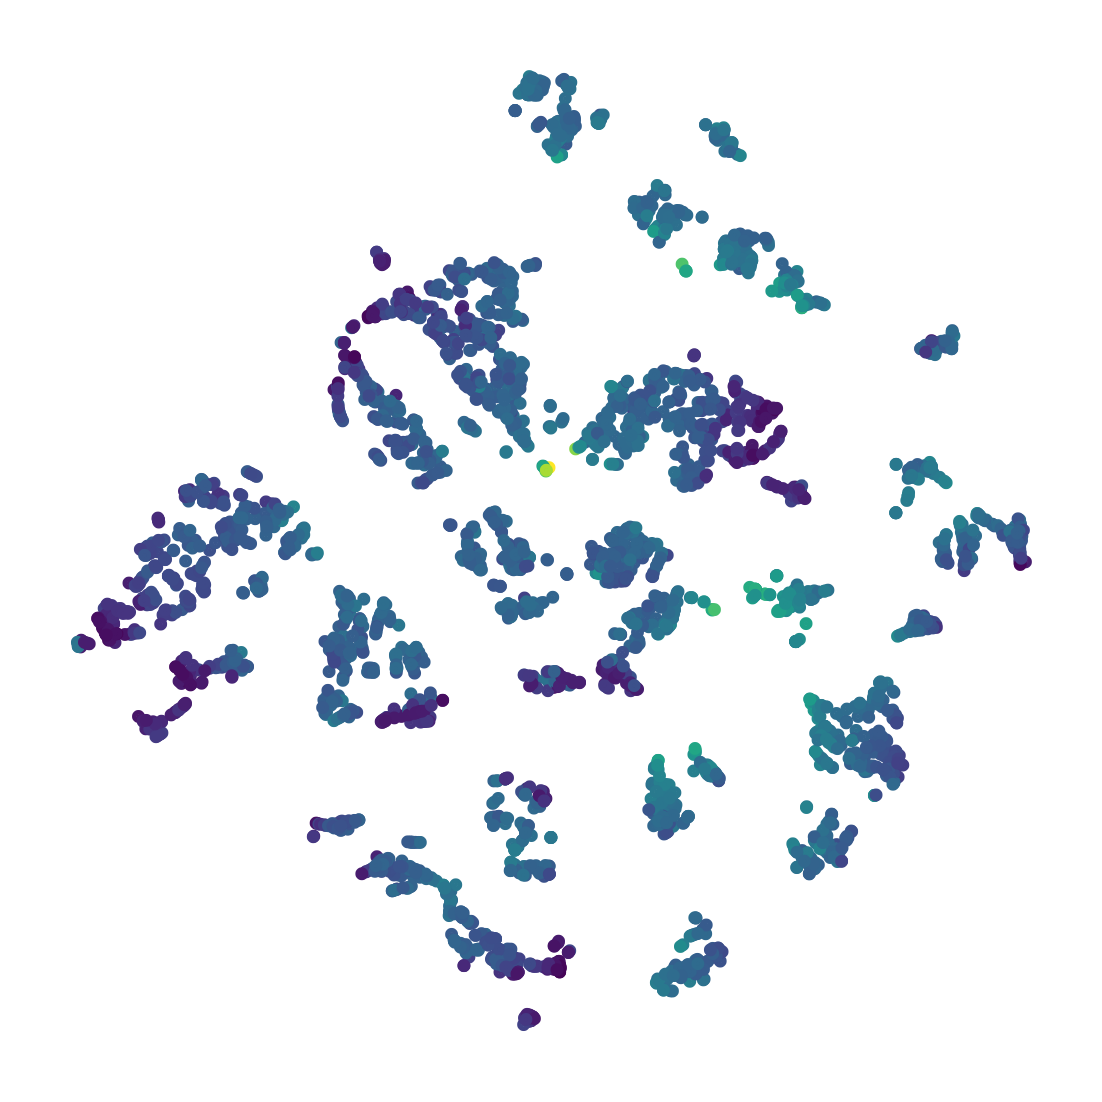

In [ ]:
figure_dir = Path().cwd() / "figures"
fig, ax = plt.subplots()
ax.scatter(fps_pca[:,0],fps_pca[:,1],c=y_normed, marker="o", s = 0.3, cmap="viridis")
ax.set_box_aspect(1)
ax.set_axis_off()
# ax.set_title("logK")
fig.savefig(figure_dir / "pca" / f"logK.pdf")

fig, ax = plt.subplots()
ax.scatter(fps_tsne[:,0],fps_tsne[:,1],c=y_normed, marker="o", s=0.3)
ax.set_box_aspect(1)
ax.set_axis_off()
# ax.set_title("logK")
fig.savefig(figure_dir / "tsne" / f"logK.pdf")

for feature in features:
    pfz = PropFeaturizer([feature])
    fig, ax = plt.subplots()
    ax.scatter(fps_pca[:,0],fps_pca[:,1],
               c=scaler.fit_transform([pfz(Chem.MolFromSmiles(i)) for i in df["Solute"]]),
               marker="o", s=0.3)
    # ax.set_title(f"{feature}",fontsize=12)
    ax.set_box_aspect(1)
    ax.set_axis_off()
    fig.savefig(figure_dir / "pca" / f"solute_{feature}.pdf")
    plt.close()

    fig, ax = plt.subplots()
    ax.scatter(fps_pca[:,0],fps_pca[:,1],
               c=scaler.fit_transform([pfz(Chem.MolFromSmiles(i)) for i in df["Solvent"]]),
               marker="o", s=0.3)
    # ax.set_title(f"{feature}",fontsize=12)
    ax.set_box_aspect(1)
    ax.set_axis_off()
    fig.savefig(figure_dir / "pca" / f"solvent_{feature}.pdf")
    plt.close()
    
    fig, ax = plt.subplots()
    ax.scatter(fps_tsne[:,0],fps_tsne[:,1],
               c=scaler.fit_transform([pfz(Chem.MolFromSmiles(i)) for i in df["Solute"]]),
               marker="o", s=0.3)
    # ax.set_title(f"{feature}",fontsize=12)
    ax.set_box_aspect(1)
    ax.set_axis_off()
    fig.savefig(figure_dir / "tsne" / f"solute_{feature}.pdf")
    plt.close()
    
    fig, ax = plt.subplots()
    ax.scatter(fps_tsne[:,0],fps_tsne[:,1],
               c=scaler.fit_transform([pfz(Chem.MolFromSmiles(i)) for i in df["Solvent"]]),
               marker="o", s=0.3)
    # ax.set_title(f"{feature}",fontsize=12)
    ax.set_box_aspect(1)
    ax.set_axis_off()
    fig.savefig(figure_dir / "tsne" / f"solvent_{feature}.pdf")
    plt.close()


In [66]:
pf = PropFeaturizer(features)
dctors = np.hstack([np.vstack(df["Solvent"].apply(lambda x: pf(Chem.MolFromSmiles(x)))),
          np.vstack(df["Solute"].apply(lambda x: pf(Chem.MolFromSmiles(x))))])
df_dctors = pd.DataFrame(dctors)
df_dctors.columns = [f"solv_{f}" for f in features] + [f"solt_{f}" for f in features]
df_dctors["logK"] = y
result = sm.ols(formula="logK ~ -1 + " + " + ".join(df_dctors.columns[:-1]),data=df_dctors).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   logK   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              4056.
Date:                Mon, 06 May 2024   Prob (F-statistic):                        0.00
Time:                        15:19:42   Log-Likelihood:                         -3975.0
No. Observations:                3658   AIC:                                      7982.
Df Residuals:                    3642   BIC:                                      8081.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
solv_TPSA                 -0.0260      0.003     -9.875      0.000      -0.031      -0.021
solv_LASA                  0.0204      0.004      4.824      0.000       0.012       0.029
solv_NumRotatableBonds     0.1014      0.009     10.775      0.000       0.083       0.120
solv_NumHDonors           -0.0745      0.036     -2.048      0.041      -0.146      -0.003
solv_NumHAcceptors         0.2251      0.037      6.098      0.000       0.153       0.298
solv_MolLogP              -0.0370      0.032     -1.148      0.251      -0.100       0.026
solv_MolMR                -0.0575      0.006     -9.184      0.000      -0.070      -0.045
solv_AromProp              0.3337      0.054      6.158      0.000       0.227       0.440
solt_TPSA                  0.0098      0.002      4.912      0.000       0.006       0.014
solt_LASA                  0.0237      0.002     15.338      0.000       0.021       0.027
solt_NumRotatableBonds    -0.1233      0.010    -11.952      0.000      -0.144      -0.103
solt_NumHDonors            0.6577      0.039     16.865      0.000       0.581       0.734
solt_NumHAcceptors        -0.0382      0.041     -0.933      0.351      -0.118       0.042
solt_MolLogP              -0.7470      0.036    -21.026      0.000      -0.817      -0.677
solt_MolMR                 0.1511      0.003     46.975      0.000       0.145       0.157
solt_AromProp              0.2745      0.055      5.025      0.000       0.167       0.382
==============================================================================
Omnibus:                      163.521   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.365
Skew:                           0.390   Prob(JB):                     7.88e-57
Kurtosis:                       4.042   Cond. No.                         379.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
[result.pvalues > 1e-5]

[solv_TPSA                 False
 solv_LASA                 False
 solv_NumRotatableBonds    False
 solv_NumHDonors            True
 solv_NumHAcceptors        False
 solv_MolLogP               True
 solv_MolMR                False
 solv_AromProp             False
 solt_TPSA                 False
 solt_LASA                 False
 solt_NumRotatableBonds    False
 solt_NumHDonors           False
 solt_NumHAcceptors         True
 solt_MolLogP              False
 solt_MolMR                False
 solt_AromProp             False
 dtype: bool]

# Chemprop (GNN)

In [8]:
class MulticomponentTrainingBatch(NamedTuple):
    bmgs: list[BatchMolGraph]
    V_ds: list[Tensor | None]
    X_d: Tensor | None
    Y: Tensor | None
    w: Tensor
    lt_mask: Tensor | None
    gt_mask: Tensor | None


def custom_collate_multicomponent(batches: Iterable[Iterable[Datum]]) -> MulticomponentTrainingBatch:
    tbs = [collate_batch(batch) for batch in zip(*batches)]
    return MulticomponentTrainingBatch(
        [tb.bmg for tb in tbs],
        [tb.V_d for tb in tbs],
        torch.cat([tbs[0].X_d,tbs[1].X_d],axis=1),
        tbs[0].Y,
        tbs[0].w,
        tbs[0].lt_mask,
        tbs[0].gt_mask,
    )

def custom_build_dataloader(
    dataset: MoleculeDataset | ReactionDataset | MulticomponentDataset,
    batch_size: int = 64,
    num_workers: int = 0,
    class_balance: bool = False,
    seed: int | None = None,
    shuffle: bool = True,
    **kwargs,
):

    if class_balance:
        sampler = ClassBalanceSampler(dataset.Y, seed, shuffle)
    elif shuffle and seed is not None:
        sampler = SeededSampler(len(dataset), seed)
    else:
        sampler = None

    if isinstance(dataset, MulticomponentDataset):
        collate_fn = custom_collate_multicomponent
    else:
        collate_fn = collate_batch

    if len(dataset) % batch_size == 1:
        warnings.warn(
            f"Dropping last batch of size 1 to avoid issues with batch normalization \
(dataset size = {len(dataset)}, batch_size = {batch_size})"
        )
        drop_last = True
    else:
        drop_last = False

    return DataLoader(
        dataset,
        batch_size,
        sampler is None and shuffle,
        sampler,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=drop_last,
        **kwargs,
    )

In [9]:
features = ["TPSA", "LASA", "NumRotatableBonds", "NumHDonors", "NumHAcceptors", "MolLogP", "MolMR", "AromProp"]

data_dir = Path.cwd() / "data"
train_file = data_dir / "solvation_train.csv"
test_file = data_dir / "solvation_test.csv"
prop_file = data_dir / "molecule_props.csv"
smiles_columns = ['Solute', 'Solvent'] # name of the column containing SMILES strings
target_columns = ['logK'] # list of names of the columns containing targets
df_input = pd.read_csv(train_file)
smiss = df_input.loc[:, smiles_columns].values
ys = df_input.loc[:, target_columns].values

split_type="random"
split = (0.8, 0.1, 0.1)

mfs = [PropFeaturizer(features)]
all_data = [[data.MoleculeDatapoint.from_smi(smis[0], y, mfs=mfs) for smis, y in zip(smiss, ys)]]
all_data += [[data.MoleculeDatapoint.from_smi(smis[i], mfs=mfs) for smis in smiss] for i in range(1, len(smiles_columns))]

component_to_split_by = 0
mols = [d.mol for d in all_data[component_to_split_by]]

train_indices, val_indices, test_indices = data.make_split_indices(mols, split_type, split)

train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_datasets = [data.MoleculeDataset(train_data[i], featurizer) for i in range(len(smiles_columns))]
train_mcdset = data.MulticomponentDataset(train_datasets)
scaler_target = train_mcdset.normalize_targets()
# scaler_input = train_mcdset.normalize_inputs(key="X_d")
train_loader = custom_build_dataloader(train_mcdset)

val_datasets = [data.MoleculeDataset(val_data[i], featurizer) for i in range(len(smiles_columns))]
val_mcdset = data.MulticomponentDataset(val_datasets)
val_mcdset.normalize_targets(scaler_target)
# val_mcdset.normalize_inputs(key="X_d",scaler=scaler_input)
val_loader = custom_build_dataloader(val_mcdset, shuffle=False)

test_datasets = [data.MoleculeDataset(test_data[i], featurizer) for i in range(len(smiles_columns))]
test_mcdset = data.MulticomponentDataset(test_datasets)
# test_mcdset.normalize_inputs(key="X_d",scaler=scaler_input)
test_loader = custom_build_dataloader(test_mcdset, shuffle=False)

In [12]:
class MulticomponentMPNN:
    def __init__(self, smiles_columns, scaler_target, features, hidden_dim=1900, n_layers=2, dropout=0.008, depth=6, max_lr=0.001):
        # Initialize the Multicomponent Message Passing Neural Network component
        self.mcmp = nn.MulticomponentMessagePassing(
            blocks=[nn.BondMessagePassing(depth=depth) for _ in range(len(smiles_columns))],
            n_components=len(smiles_columns),
        )

        # Initialize the aggregation method
        self.agg = nn.MeanAggregation()

        # Output transform setup
        self.output_transform = nn.UnscaleTransform.from_standard_scaler(scaler_target)

        # Fully connected feedforward network
        self.ffn = nn.RegressionFFN(
            input_dim=self.mcmp.output_dim + 2 * len(features),
            output_transform=self.output_transform,
            hidden_dim=hidden_dim,
            n_layers=n_layers,
            dropout=dropout,
        )

        # Metric list setup
        self.metric_list = [nn.metrics.RMSEMetric(), nn.metrics.MAEMetric(), nn.metrics.R2Metric()]

        # Final MPNN model composition
        self.model = models.multi.MulticomponentMPNN(
            self.mcmp,
            self.agg,
            self.ffn,
            metrics=self.metric_list,
            max_lr=max_lr
        )

    def get_model(self):
        return self.model
    
mcmpnn = MulticomponentMPNN(smiles_columns, scaler_target, features, hidden_dim=1900, n_layers=2, dropout=0.008)

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.


In [ ]:
print(mcmpnn.get_model())

MulticomponentMPNN(
  (message_passing): MulticomponentMessagePassing(
    (blocks): ModuleList(
      (0-1): 2 x BondMessagePassing(
        (W_i): Linear(in_features=86, out_features=300, bias=False)
        (W_h): Linear(in_features=300, out_features=300, bias=False)
        (W_o): Linear(in_features=372, out_features=300, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (tau): ReLU()
        (V_d_transform): Identity()
        (graph_transform): Identity()
      )
    )
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=616, out_features=1900, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.008, inplace=False)
        (2): Linear(in_features=1900, out_features=1900, bias=True)
      )
      (2): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.008, i

In [ ]:
logger = CSVLogger("logs", name="model")

trainer = pl.Trainer(
    logger=logger,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="gpu",
    devices=1,
    max_epochs=200, # number of epochs to train for
)

trainer.fit(mcmpnn.get_model(), train_loader, val_loader)

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Epoch 199: 100%|██████████| 46/46 [00:01<00:00, 33.55it/s, v_num=23, train_loss=0.00231, val_loss=0.129] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 46/46 [00:01<00:00, 30.49it/s, v_num=23, train_loss=0.00231, val_loss=0.129]


In [ ]:
results = trainer.test(mcmpnn.get_model(), test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 47.80it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.10145554691553116
 batch_averaged_test/r2     0.9895522594451904
batch_averaged_test/rmse    0.15969231724739075
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
kaggle_path = data_dir / "solvation_test.csv"
df_kaggle = pd.read_csv(kaggle_path)
smiss_kaggle = df_kaggle.loc[:, smiles_columns].values
kaggle_data = [[data.MoleculeDatapoint.from_smi(smis[0], mfs=mfs) for smis in smiss_kaggle]]
kaggle_data += [[data.MoleculeDatapoint.from_smi(smis[1], mfs=mfs) for smis in smiss_kaggle]]
kaggle_datasets = [data.MoleculeDataset(kaggle_data[i], featurizer) for i in range(len(smiles_columns))]
kaggle_mcdset = data.MulticomponentDataset(kaggle_datasets)
# kaggle_mcdset.normalize_inputs(key="X_d",scaler=scaler_input)
kaggle_loader = custom_build_dataloader(kaggle_mcdset,shuffle=False)

In [ ]:
test_preds = trainer.predict(mcmpnn.get_model(), kaggle_loader)
test_preds = np.concatenate(test_preds, axis=0)
formatted_time = datetime.now().strftime("%Y%m%d-%H%M")
save_submission(test_preds.squeeze(),f"kaggle/chemprop_{formatted_time}.csv")

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 55.83it/s]


In [ ]:
def objective(trial: optuna.Trial) -> float:
    hidden_dim = trial.suggest_int("hidden_dim", 100, 2400)
    n_layers = trial.suggest_int("n_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    depth = trial.suggest_int("depth", 2, 6)
    max_epochs = trial.suggest_int("max_epochs", 50, 200)

    mcmpnn = MulticomponentMPNN(smiles_columns, scaler, features, hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout, depth=depth)

    logger = CSVLogger("logs", name="hyperparameter")

    trainer = pl.Trainer(
        logger=logger,
        enable_checkpointing=True,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss")],
        enable_progress_bar=False,
        accelerator="gpu",
        devices=1,
        max_epochs=max_epochs, # number of epochs to train for
    )

    hyperparameters = dict(hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout, depth=depth, max_epochs=max_epochs)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(mcmpnn.get_model(), train_loader, val_loader)  # Define your dataloaders properly

    return trainer.callback_metrics["val_loss"].item()  # Or any other metric that you aim to minimize

# Create a study and execute optimization
pruner = optuna.pruners.PatientPruner(optuna.pruners.HyperbandPruner(), patience=3)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=200)  # You can adjust the number of trials

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [15]:
import warnings
kf = KFold(n_splits=5)
result_lst = []
for i, (train_indices, test_indices) in enumerate(kf.split(mols)):
    train_data, val_data, test_data = data.split_data_by_indices(
        all_data, train_indices, [0], test_indices
    )

    featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

    train_datasets = [data.MoleculeDataset(train_data[i], featurizer) for i in range(len(smiles_columns))]
    train_mcdset = data.MulticomponentDataset(train_datasets)
    scaler_target = train_mcdset.normalize_targets()
    # scaler_input = train_mcdset.normalize_inputs(key="X_d")
    train_loader = custom_build_dataloader(train_mcdset)

    val_datasets = [data.MoleculeDataset(val_data[i], featurizer) for i in range(len(smiles_columns))]
    val_mcdset = data.MulticomponentDataset(val_datasets)
    val_mcdset.normalize_targets(scaler_target)
    # val_mcdset.normalize_inputs(key="X_d",scaler=scaler_input)
    val_loader = custom_build_dataloader(val_mcdset, shuffle=False)

    test_datasets = [data.MoleculeDataset(test_data[i], featurizer) for i in range(len(smiles_columns))]
    test_mcdset = data.MulticomponentDataset(test_datasets)
    # test_mcdset.normalize_inputs(key="X_d",scaler=scaler_input)
    test_loader = custom_build_dataloader(test_mcdset, shuffle=False)
    
    mcmpnn = MulticomponentMPNN(smiles_columns, scaler_target, features, hidden_dim=1923, n_layers=2,
                                dropout=0.016717180169380612, max_lr=0.006944491033377218, depth=5)

    logger = CSVLogger("logs", name="model")

    trainer = pl.Trainer(
            logger=logger,
            enable_checkpointing=True,
            enable_progress_bar=True,
            accelerator="gpu",
            devices=1,
            max_epochs=89, # number of epochs to train for
        )

    trainer.fit(mcmpnn.get_model(), train_loader, val_loader)
    results = trainer.test(mcmpnn.get_model(), test_loader)
    result_lst.append(results[0]["batch_averaged_test/r2"])

/tmp/ipykernel_2956191/2016782832.py:46: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOC

Loading `train_dataloader` to estimate number of stepping batches.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | message_passing | MulticomponentMessagePassing | 455 K 
1 | agg             | MeanAggregation              | 0     
2 | bn              | BatchNorm1d                  | 1.

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 37.83it/s, v_num=426, train_loss=0.00136] 

`Trainer.fit` stopped: `max_epochs=89` reached.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 34.30it/s, v_num=426, train_loss=0.00136]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 48.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.09952425211668015
 batch_averaged_test/r2      0.990231990814209
batch_averaged_test/rmse    0.16667978465557098
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/tmp/ipykernel_2956191/2016782832.py:46: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOC

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 37.91it/s, v_num=427, train_loss=0.00237] 

`Trainer.fit` stopped: `max_epochs=89` reached.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 32.36it/s, v_num=427, train_loss=0.00237]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 47.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.09727423638105392
 batch_averaged_test/r2     0.9913933873176575
batch_averaged_test/rmse    0.1575765460729599
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/tmp/ipykernel_2956191/2016782832.py:46: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOC

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 37.74it/s, v_num=428, train_loss=0.00255] 

`Trainer.fit` stopped: `max_epochs=89` reached.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 34.09it/s, v_num=428, train_loss=0.00255]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 47.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.0980943813920021
 batch_averaged_test/r2     0.9895720481872559
batch_averaged_test/rmse     0.164480522274971
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/tmp/ipykernel_2956191/2016782832.py:46: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOC

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 37.89it/s, v_num=429, train_loss=0.00266] 

`Trainer.fit` stopped: `max_epochs=89` reached.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 34.22it/s, v_num=429, train_loss=0.00266]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 49.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.1004645898938179
 batch_averaged_test/r2     0.9875091910362244
batch_averaged_test/rmse    0.1690697818994522
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/tmp/ipykernel_2956191/2016782832.py:46: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOC

/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 38.06it/s, v_num=430, train_loss=0.00186] 

`Trainer.fit` stopped: `max_epochs=89` reached.


Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 34.46it/s, v_num=430, train_loss=0.00186]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 48.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.09760073572397232
 batch_averaged_test/r2     0.9896097779273987
batch_averaged_test/rmse    0.16167032718658447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [16]:
write("DMPNN",result_lst)

# XGBoost

In [ ]:
def featurize(smiles):
    mol = Chem.MolFromSmiles(smiles) # load SMILES into RDKit
    fp = AllChem.GetMorganGenerator(radius=2, fpSize=1024)
    fp_array = np.array(fp.GetFingerprint(mol))
    featurizer = PropFeaturizer(features)
    return np.hstack([fp_array, featurizer(mol)])

In [ ]:
data_dir = Path.cwd() / "data"
train_file = data_dir / "solvation_train.csv"
test_file = data_dir / "solvation_test.csv"
prop_file = data_dir / "molecule_props.csv"
df = pd.read_csv(train_file) # load data
mol_prop = pd.read_csv(prop_file)
y = df["logK"]
X_solvent = np.stack(df["Solvent"].apply(featurize).values)
X_solute = np.stack(df["Solute"].apply(featurize).values)
X = np.hstack([X_solvent,X_solute])

In [ ]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "device": "cuda"
    }

    bst = XGBRegressor(**params)
    pipe = Pipeline([('scaler', StandardScaler()), ('model', bst)])
    scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
    return scores.mean()

In [79]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-06 15:49:44,724] A new study created in memory with name: no-name-ab86d0cd-6675-4ffd-995e-b8d772c4546d
[I 2024-05-06 15:49:59,453] Trial 0 finished with value: 0.9314558463266639 and parameters: {'n_estimators': 620, 'learning_rate': 0.01881907824016294, 'max_depth': 3, 'subsample': 0.3654950657585666, 'colsample_bytree': 0.8612461064872369, 'min_child_weight': 14}. Best is trial 0 with value: 0.9314558463266639.
[I 2024-05-06 15:50:13,045] Trial 1 finished with value: 0.6227098201036345 and parameters: {'n_estimators': 452, 'learning_rate': 0.0013801994568370182, 'max_depth': 10, 'subsample': 0.7791248907072018, 'colsample_bytree': 0.6323995345043142, 'min_child_weight': 19}. Best is trial 0 with value: 0.9314558463266639.
[I 2024-05-06 15:50:18,660] Trial 2 finished with value: 0.9609057342033708 and parameters: {'n_estimators': 507, 'learning_rate': 0.08271379894698898, 'max_depth': 5, 'subsample': 0.7626307577689471, 'colsample_bytree': 0.6406831709648182, 'min_child_wei

In [87]:
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
params = trial.params
params["objective"] =  "reg:squarederror"
params["verbosity"] =  0
params["device"] =  "cuda"
params

Best trial:
  Value: 0.9799330132403803
  Params: 
    n_estimators: 850
    learning_rate: 0.043618536313187406
    max_depth: 9
    subsample: 0.7554948276711327
    colsample_bytree: 0.6508682722614273
    min_child_weight: 1


{'n_estimators': 850,
 'learning_rate': 0.043618536313187406,
 'max_depth': 9,
 'subsample': 0.7554948276711327,
 'colsample_bytree': 0.6508682722614273,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'verbosity': 0,
 'device': 'cuda'}

In [17]:
params = {'n_estimators': 850,
 'learning_rate': 0.043618536313187406,
 'max_depth': 9,
 'subsample': 0.7554948276711327,
 'colsample_bytree': 0.6508682722614273,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'verbosity': 0,
 'device': 'cuda'}

fingerprinters = {"RDKit":AllChem.GetRDKitFPGenerator().GetFingerprint,
"TopologicalTorsion":AllChem.GetTopologicalTorsionGenerator().GetFingerprint,
"Morgan":AllChem.GetMorganGenerator().GetFingerprint,
"Avalon":GetAvalonFP,
}

def objective(trial):
    features = ["TPSA", "LASA", "NumRotatableBonds", "NumHDonors", "NumHAcceptors", "MolLogP", "MolMR", "AromProp"]

    fp = trial.suggest_categorical("fingerprint", ["RDKit", "Morgan", "TopologicalTorsion", "Avalon"])
    
    def featurize(smiles):
        mol = Chem.MolFromSmiles(smiles) # load SMILES into RDKit
        fp_array = np.array(fingerprinters[fp](mol))
        featurizer = PropFeaturizer(features)
        return np.hstack([fp_array, featurizer(mol)])

    data_dir = Path.cwd() / "data"
    train_file = data_dir / "solvation_train.csv"
    test_file = data_dir / "solvation_test.csv"
    prop_file = data_dir / "molecule_props.csv"
    df = pd.read_csv(train_file) # load data
    mol_prop = pd.read_csv(prop_file)
    y = df["logK"]
    X_solvent = np.stack(df["Solvent"].apply(featurize).values)
    X_solute = np.stack(df["Solute"].apply(featurize).values)
    X = np.hstack([X_solvent,X_solute])

    bst = XGBRegressor(**params)
    pipe = Pipeline([('scaler', StandardScaler()), ('model', bst)])
    scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
    return scores.mean()

In [18]:
search_space = {"fingerprint": ["RDKit", "Morgan", "TopologicalTorsion", "Avalon"]}

In [13]:
study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space=search_space),direction="maximize")
study.optimize(objective, n_trials=4)

[I 2024-05-06 17:16:31,885] A new study created in memory with name: no-name-7dd6d12f-3815-4231-b167-9d596ddd4275
[I 2024-05-06 17:17:00,415] Trial 0 finished with value: 0.9795121505157198 and parameters: {'fingerprint': 'Morgan'}. Best is trial 0 with value: 0.9795121505157198.
[I 2024-05-06 17:17:33,096] Trial 1 finished with value: 0.9774261767734679 and parameters: {'fingerprint': 'RDKit'}. Best is trial 0 with value: 0.9795121505157198.
[I 2024-05-06 17:17:54,623] Trial 2 finished with value: 0.9796385900905642 and parameters: {'fingerprint': 'Avalon'}. Best is trial 2 with value: 0.9796385900905642.
[I 2024-05-06 17:18:24,409] Trial 3 finished with value: 0.9779505049994196 and parameters: {'fingerprint': 'TopologicalTorsion'}. Best is trial 2 with value: 0.9796385900905642.


In [19]:
bst = XGBRegressor(**params)
pipe = Pipeline([('scaler', StandardScaler()), ('model', bst)])
scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
print(f"XGBoost R2: {scores.mean()}")
write("XGBoost",scores)
bst.fit(X,y)

XGBoost R2: 0.9784718473940185


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6508682722614273, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.043618536313187406, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=850, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
bst = XGBRegressor(**params)
bst.fit(X,np.array(y))
predict = bst.predict(X_kaggle)

In [ ]:
formatted_time = datetime.now().strftime("%Y%m%d-%H%M")
save_submission(np.array(predict),f"kaggle/xgboost_{formatted_time}.csv")

# Random Forest

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2'])
    }

    reg = RandomForestRegressor(**params)
    pipe = Pipeline([('scaler', StandardScaler()), ('model', reg)])
    scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
    return scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-05 16:21:00,882] A new study created in memory with name: no-name-8b88dac8-4e95-476d-bd83-7e2411c4e294
[I 2024-05-05 16:21:03,918] Trial 0 finished with value: 0.49786962674195284 and parameters: {'n_estimators': 293, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.49786962674195284.
[I 2024-05-05 16:21:10,751] Trial 1 finished with value: 0.42358861500157935 and parameters: {'n_estimators': 871, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.49786962674195284.
[I 2024-05-05 16:21:15,633] Trial 2 finished with value: 0.4094141827138721 and parameters: {'n_estimators': 596, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.49786962674195284.
[I 2024-05-05 16:21:18,682] Trial 3 finished with value: 0.18884169630155895 and parameters: {'n_estimators': 474, 'max_depth': 

In [20]:
params = {
    "n_estimators": 452,
    "max_depth": 10,
    'min_samples_split': 3,
    'min_samples_leaf': 1,
    'max_features': "sqrt"
}

reg = RandomForestRegressor(**params)
pipe = Pipeline([('scaler', StandardScaler()), ('model', reg)])
scores = cross_val_score(pipe, X, y, cv = 5, scoring = "r2")
print(f"RandomForest R2: {scores.mean()}")
write("RandomForest",scores)

RandomForest R2: 0.7145852105049967


# MLP Fingerprint Regression

In [19]:
from torch.utils.data import Dataset, DataLoader
fpSize = 1024
features = ["TPSA", "LASA", "NumRotatableBonds", "NumHDonors", "NumHAcceptors", "MolLogP", "MolMR", "AromProp"]
def featurize(smiles):
    mol = Chem.MolFromSmiles(smiles) # load SMILES into RDKit
    fp = AllChem.GetMorganGenerator(radius=2, fpSize=fpSize)
    fp_array = np.array(fp.GetFingerprint(mol))
    featurizer = PropFeaturizer(features)
    return np.hstack([fp_array, featurizer(mol)])

y = df["logK"]
X_solvent = np.stack(df["Solvent"].apply(featurize).values)
X_solute = np.stack(df["Solute"].apply(featurize).values)
X = np.hstack([X_solvent,X_solute])

class Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(np.array(X))  # store X as a pytorch Tensor
        self.y = torch.Tensor(np.array(y))  # store y as a pytorch Tensor
        self.len=len(self.X)                # number of samples in the data

    def __getitem__(self, index):
        return self.X[index], self.y[index] # get the appropriate item

    def __len__(self):
        return self.len

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1/0.9,train_size=0.8/0.9)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

train_data = Dataset(X_train,y_train)
val_data = Dataset(X_val,y_val)
test_data = Dataset(X_test,y_test)

batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [21]:
class FFN(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim=256, n_layers=1, dropout=0, lr=0.001):
        super().__init__()
        self.lr = lr
        model = [torch.nn.Linear(input_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Dropout(dropout)]
        model += [torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Dropout(dropout)] * n_layers
        model.append(torch.nn.Linear(hidden_dim, 1))  # Final layer
        self.model = torch.nn.Sequential(*model)  # Assign the correct variable to torch.nn.Sequential

    def forward(self, x):
        x = x.squeeze()
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = torch.nn.functional.mse_loss(output.squeeze(), y) 
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = torch.nn.functional.mse_loss(output.squeeze(), y) 
        self.log("val_loss", loss, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = torch.nn.functional.mse_loss(output.squeeze(), y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_r2", r2(output.squeeze(),y), prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=self.lr)

In [22]:
import logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

In [23]:
def objective(trial):
    params = {
        "hidden_dim": trial.suggest_int("hidden_dim", 200, 2400),
        "n_layers": trial.suggest_int("n_layers", 1, 5),
        'dropout': trial.suggest_float("dropout", 0.0, 0.4),
        "lr": trial.suggest_float("lr", 1e-3, 0.1, log=True),
    }
    max_epochs =  trial.suggest_int("max_epochs", 50, 200)

    ffn = FFN(input_dim=fpSize*2+len(features)*2, **params)

    logger = CSVLogger("logs", name="model")

    trainer = pl.Trainer(
        logger=logger,
        enable_checkpointing=True,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss")],
        enable_progress_bar=False,
        accelerator="gpu",
        devices=1,
        max_epochs=max_epochs, # number of epochs to train for
    )

    hyperparameters = dict(max_epochs=max_epochs, **params)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(ffn, train_loader, val_loader)  # Define your dataloaders properly

    return trainer.callback_metrics["val_loss"].item()  # Or any other metric that you aim to minimize

# Create a study and execute optimization
pruner = optuna.pruners.PatientPruner(optuna.pruners.HyperbandPruner(), patience=3)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=200)  # You can adjust the number of trials

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

/tmp/ipykernel_2956191/3856983442.py:31: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner = optuna.pruners.PatientPruner(optuna.pruners.HyperbandPruner(), patience=3)
[I 2024-05-06 23:42:57,798] A new study created in memory with name: no-name-6e08020b-08b2-4151-8958-d6b36c1b7497
/home/gridsan/ddavid/.conda/envs/torch/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/ddavid/.conda/envs/torch/lib/python3.1 ...

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 6.0 M 
-------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
23.849    Total estimated model params size (MB)
/home/gridsan/dd

In [ ]:
kf = KFold(n_splits=5)
result_lst = []
for i, (train_indices, test_indices) in enumerate(kf.split(mols)):
    X_train = X[train_indices,:]
    y_train = np.array(y)[train_indices]
    X_test = X[test_indices,:]
    y_test = np.array(y)[test_indices]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    train_data = Dataset(X_train,y_train)
    test_data = Dataset(X_test,y_test)

    batch_size = 64
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    hidden_dim = 256
    n_layers = 3
    dropout = 0.04625202733030247
    lr = 0.001081576060046395

    ffn = FFN(input_dim=fpSize*2+len(features)*2, hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout, lr=lr)

    logger = CSVLogger("logs", name="model")

    trainer = pl.Trainer(
        logger=logger,
        enable_checkpointing=True,
        enable_progress_bar=False,
        accelerator="gpu",
        devices=1,
        max_epochs=160, # number of epochs to train for
    )

    trainer.fit(ffn, train_loader)
    results = trainer.test(ffn, test_loader)
    result_lst.append(results[0]["test_r2"])

In [53]:
write("FFN",result_lst)

# Plot performance

/tmp/ipykernel_1151058/2476129215.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


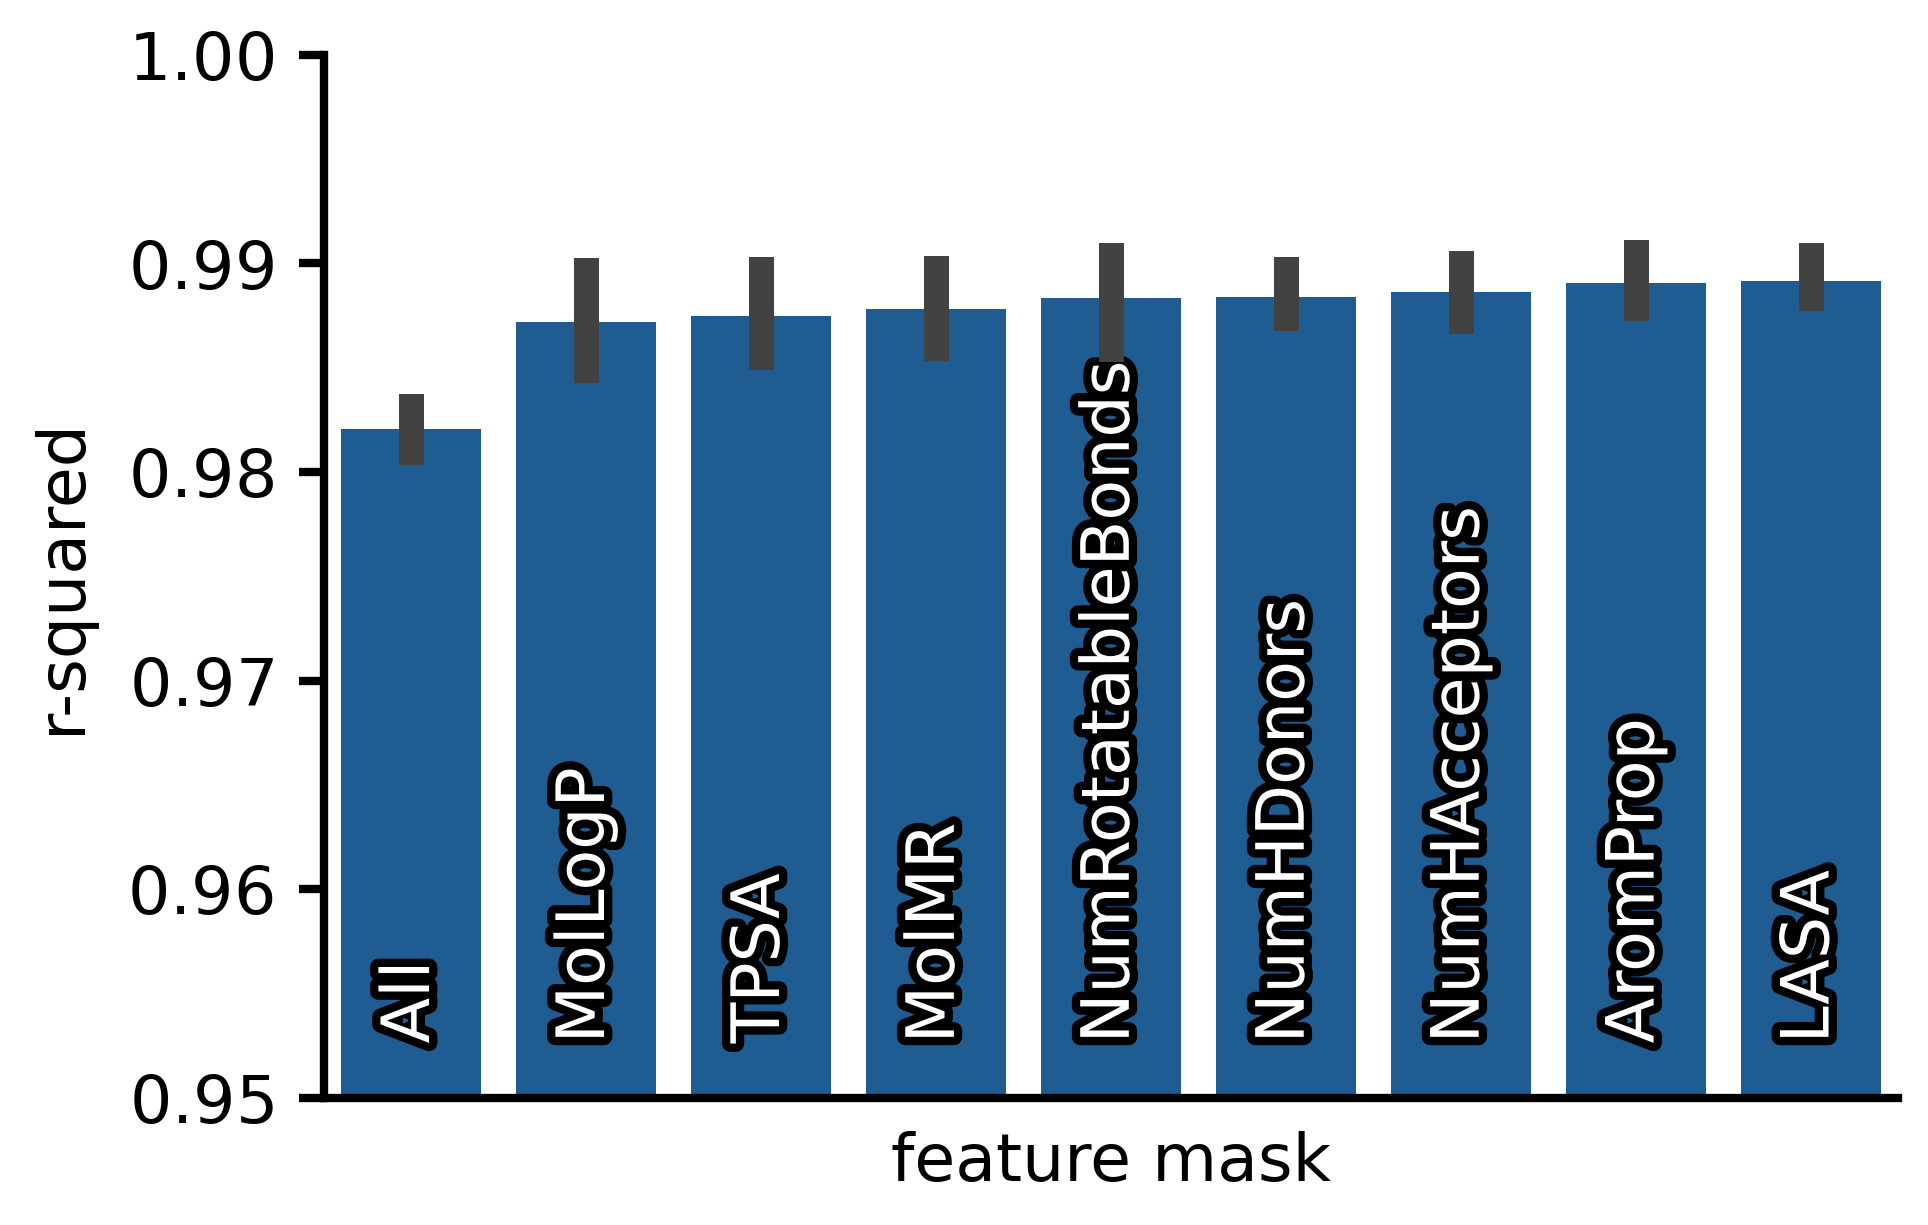

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from package import plot
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
preds = (Path().cwd() / "mask").glob("testr2_*")
lst = []
for file in preds:
    with file.open("r") as fhd:
        val = eval(fhd.read())
        r2 = val[0]["batch_averaged_test/r2"]
        lst.append([file.name.split("_")[-2], r2])
df = pd.DataFrame(lst)
df.columns = ["mask", "r2"]
features = ["TPSA", "LASA", "NumRotatableBonds", "NumHDonors", "NumHAcceptors", "MolLogP", "MolMR", "AromProp", "All", "Sig"]
df.loc[df["mask"]=="nodescriptor","mask"] = "8"
df.loc[df["mask"]=="sig","mask"] = "9"

df["mask"] = df["mask"].apply(lambda x: features[int(x)])
order = df.groupby("mask").mean()["r2"].sort_values().index
fig, ax = plt.subplots()

sns.barplot(df,x="mask",y="r2",order=order,zorder=-10)
ax.set_ylim(bottom=0.95,top=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("feature mask")
ax.set_ylabel("r-squared")
for label in ax.get_xticklabels():
    label.set_rotation(90)
    label.set_verticalalignment('bottom')  # Center alignment vertically
    label.set_y(0.1)
    label.set_color('white')
    label.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
    label.set_zorder(10)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False)
fig.savefig("masking.pdf")

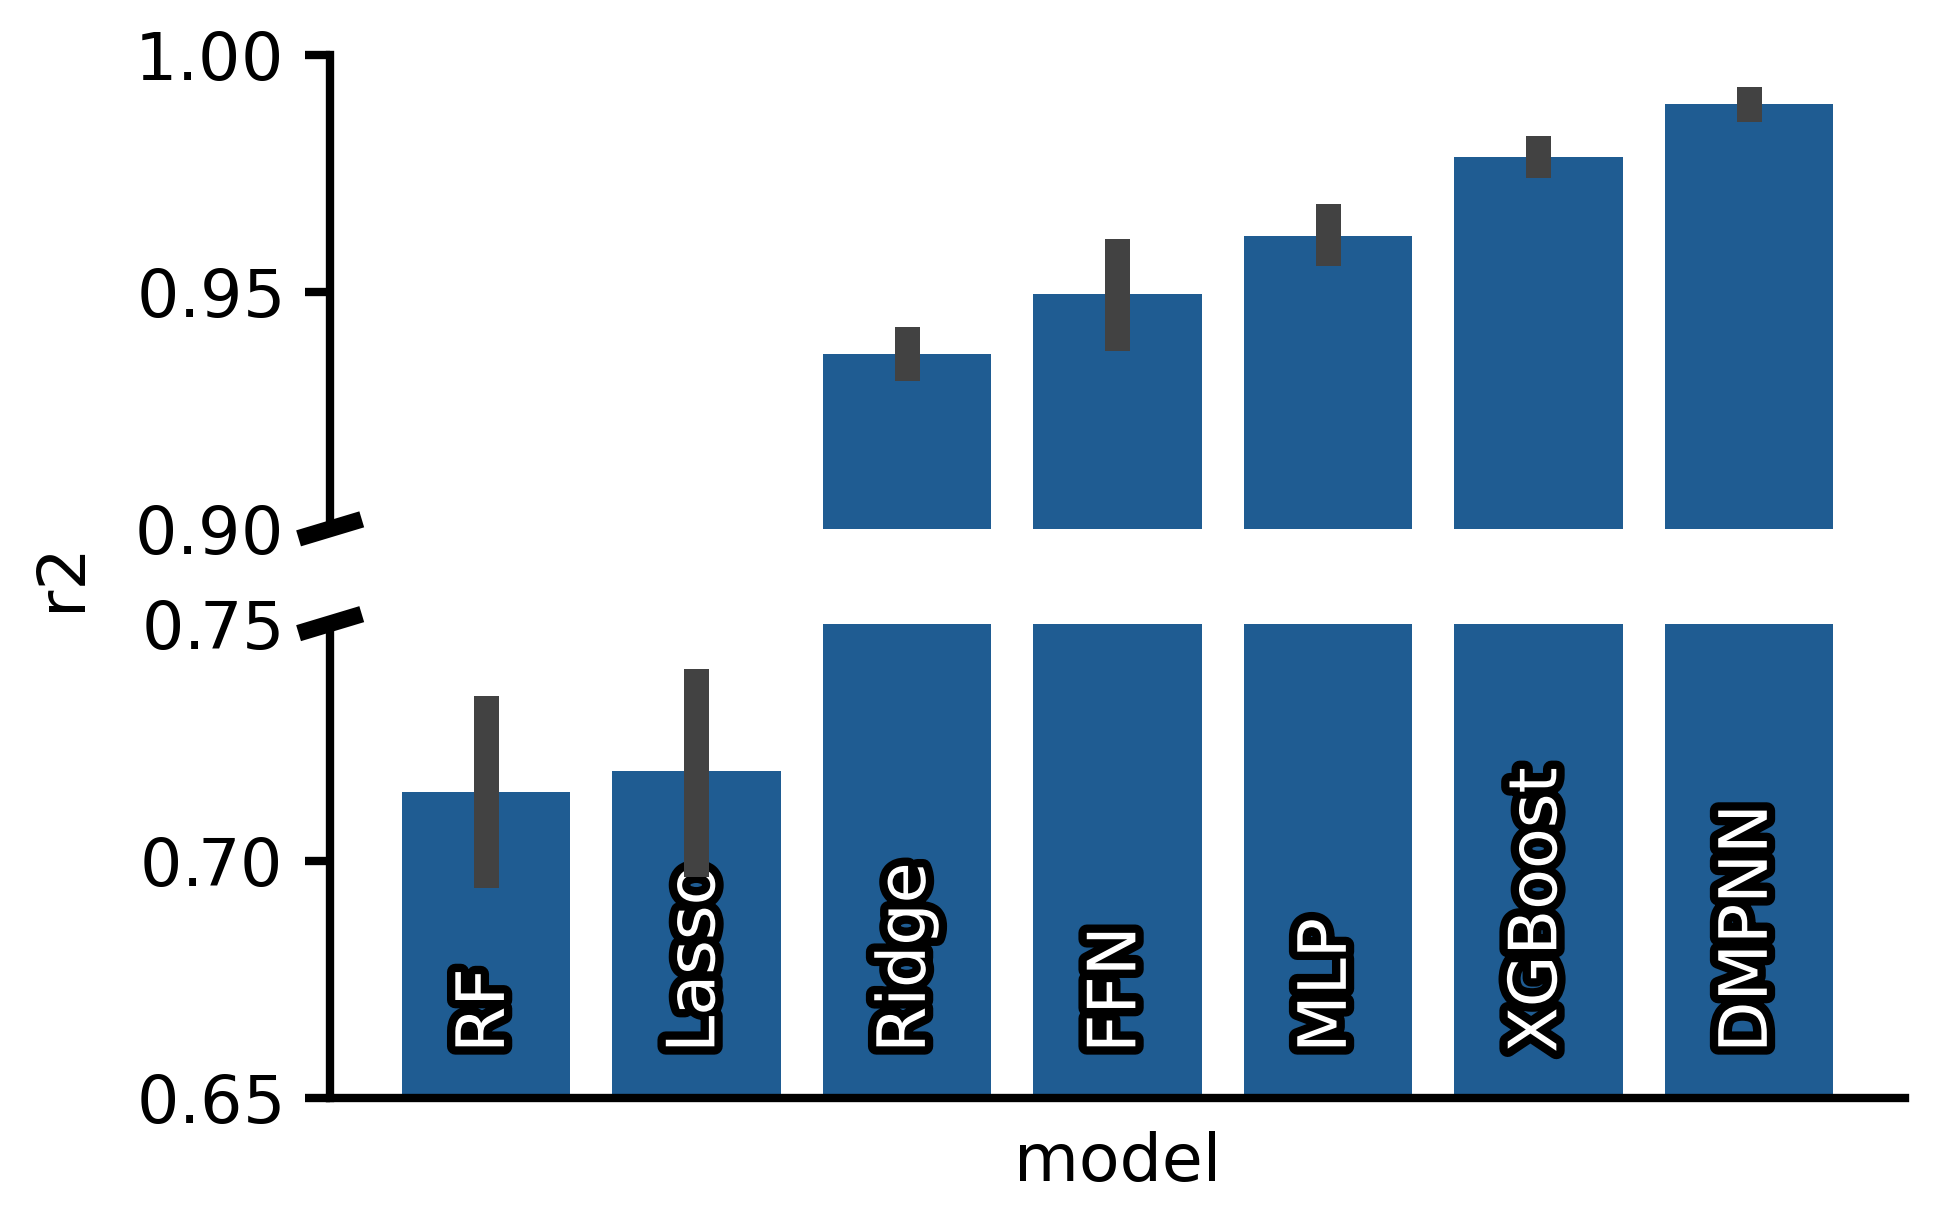

In [2]:
perf_dct = {
# "linear":[-1.95111402e+19, -6.50692697e+16, -6.10952054e+16, -2.22978565e+16, -3.52139824e+18],
"Lasso":[0.71480408, 0.7533171,  0.68961769, 0.73125985, 0.705604  ],
"Ridge":[0.9325229,  0.94038603, 0.93766374, 0.94098614, 0.93326919],
"XGBoost":[0.9787706,  0.97530457, 0.98063007, 0.97697579, 0.98067821],
"RF":[0.69742223 ,0.68523254 ,0.73478339, 0.7359476,  0.7195403 ],
"MLP":[0.95877124, 0.95719349, 0.96224141, 0.96095062, 0.9696648 ],
"FFN":[0.9570232629776001, 0.957734227180481, 0.935830295085907, 0.9366430044174194, 0.9607927203178406],
"DMPNN":[0.990231990814209, 0.9913933873176575, 0.9895720481872559, 0.9875091910362244, 0.9896097779273987]
}
perf_df = pd.DataFrame(perf_dct)
perf_df[perf_df<0]=0

melt_df = perf_df.melt(var_name="model",value_name="r2")
order = melt_df.groupby("model").mean()["r2"].sort_values().index

f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.2})
sns.barplot(x="model", y="r2", data=melt_df, ax=ax_top, order=order)
sns.barplot(x="model", y="r2", data=melt_df, ax=ax_bottom, order=order)
ax_top.set_ylim(0.9,1)   # those limits are fake
ax_bottom.set_ylim(0.65,0.75)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

ax_top.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax = ax_top
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

for label in ax_bottom.get_xticklabels():
    label.set_rotation(90)
    label.set_verticalalignment('bottom')  # Center alignment vertically
    label.set_y(0.2)
    label.set_color('white')
    label.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
    label.set_zorder(10)

ax.yaxis.get_major_ticks()[0].tick1line.set_markersize(0)
ax2.yaxis.get_major_ticks()[-1].tick1line.set_markersize(0)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False)

ax2.set_ylabel("")

ax.yaxis.set_label_coords(-0.15,-0.1)
f.savefig("model.pdf")